<a href="https://colab.research.google.com/github/adrianhutter/learning_with_opponent_transparency/blob/main/learning_with_opponent_transparency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proof-of-principle implementation of the main ideas in "Learning in two-player games between transparent opponents".

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch as T
import datetime

Calculates action-probabilities  in 2-player, 2-action games, in which both players can predict each other (cf. Sec. 3 of the paper).

In [2]:
def transparent_decision_making(params_A, params_B, epsilon=1e-3):
    """
    Decision-making under mutual transparency for a 2-player, 2-action game.
    Inputs: tensors of shape [4], describing players' parameters, which are 
    converted to probabilities using sigmoid.
    Parameter 0 -> Pr[0|~P] (probability of choosing action 0 when not 
                             predicting the opponent)
    Parameter 1 -> Pr[0|0] (probability of choosing action 0 when the opponent's 
                            predicted action is 0)
    Parameter 2 -> Pr[0|1] (probability of choosing action 0 when the opponent's 
                            predicted action is 1)
    Parameter 3 -> Pr[P] (probability of predicting the opponent)
    epsilon is the minimial probability of an opponent-independent response.
    Returns both players' probabilities of playing action 0.
    """
    probs_A = T.sigmoid(params_A[:3])
    probs_A = T.stack([probs_A, 1 - probs_A])
    v_A = probs_A[:, 0]
    M_A = probs_A[:, 1:]
    p_simu_A = T.clamp(T.sigmoid(params_A[3]), 0, 1-epsilon)

    probs_B = T.sigmoid(params_B[:3])
    probs_B = T.stack([probs_B, 1 - probs_B])
    v_B = probs_B[:, 0]
    M_B = probs_B[:, 1:]
    p_simu_B = T.clamp(T.sigmoid(params_B[3]), 0, 1-epsilon)

    R_A = (1-p_simu_A) * v_A + p_simu_A * (1-p_simu_B) * T.matmul(M_A, v_B)
    S_A = T.eye(2) - p_simu_B * p_simu_A * T.matmul(M_A, M_B)
    response_A = T.matmul(T.inverse(S_A), R_A)
    R_B = (1-p_simu_B) * v_B + p_simu_B * (1-p_simu_A) * T.matmul(M_B, v_A)
    S_B = T.eye(2) - p_simu_A * p_simu_B * T.matmul(M_B, M_A) 
    response_B = T.matmul(T.inverse(S_B), R_B)
    
    assert T.allclose(T.sum(response_A), T.tensor(1.), rtol=1e-3), \
        'response_A not normalized'
    assert T.allclose(T.sum(response_B), T.tensor(1.), rtol=1e-3), \
        'response_B not normalized'
    assert (response_A >= 0.).byte().all(), 'response_A not non-negative'
    assert (response_B >= 0.).byte().all(), 'response_B not non-negative'

    return (response_A[0], response_B[0])

For illustration, test this with a few simple agents:

*   "defector": unconditionally defects with high probability
*   "cooperator": unconditionally cooperates with high probability
* "coin fliper": takes each possible action with probability $\frac{1}{2}$.
* $\varepsilon$GroundedFairBot: cooperates unconditionally with small probability, otherwise mirrors the opponents action


In [3]:
# Assume action 0 is cooperation, and action 1 is defection.
agents = [
          ('defector', T.tensor([-20.,-20.,-20.,-20.])),
          ('cooperator', T.tensor([20.,20.,20.,-20.])),
          ('coin_fliper', T.tensor([0.,0.,0.,0.])),
          ('epsilon_grounded_fair_bot', T.tensor([20.,20.,-20.,20.])),
]
for i, agent_A in enumerate(agents):
    for j, agent_B in enumerate(agents):
        if j < i:
            continue
        pr_C_A, pr_C_B = transparent_decision_making(agent_A[1], agent_B[1])
        msg = f"Agent A = {agent_A[0]}, agent B = {agent_B[0]}, "
        msg += f"Pr[C]_A = {pr_C_A:.3f}, Pr[C]_B = {pr_C_B:.3f}"
        print(msg)

Agent A = defector, agent B = defector, Pr[C]_A = 0.000, Pr[C]_B = 0.000
Agent A = defector, agent B = cooperator, Pr[C]_A = 0.000, Pr[C]_B = 1.000
Agent A = defector, agent B = coin_fliper, Pr[C]_A = 0.000, Pr[C]_B = 0.500
Agent A = defector, agent B = epsilon_grounded_fair_bot, Pr[C]_A = 0.000, Pr[C]_B = 0.001
Agent A = cooperator, agent B = cooperator, Pr[C]_A = 1.000, Pr[C]_B = 1.000
Agent A = cooperator, agent B = coin_fliper, Pr[C]_A = 1.000, Pr[C]_B = 0.500
Agent A = cooperator, agent B = epsilon_grounded_fair_bot, Pr[C]_A = 1.000, Pr[C]_B = 1.000
Agent A = coin_fliper, agent B = coin_fliper, Pr[C]_A = 0.500, Pr[C]_B = 0.500
Agent A = coin_fliper, agent B = epsilon_grounded_fair_bot, Pr[C]_A = 0.500, Pr[C]_B = 0.501
Agent A = epsilon_grounded_fair_bot, agent B = epsilon_grounded_fair_bot, Pr[C]_A = 1.000, Pr[C]_B = 1.000


In [4]:
def actions_to_payoffs(game, p_C_A, p_C_B):
    p_CC, p_CD, p_DC, p_DD = p_C_A * p_C_B, p_C_A * (1-p_C_B), \
                             (1-p_C_A) * p_C_B, (1-p_C_A) * (1-p_C_B)
    if game == 'prisoners_dilemma':
        S, P, R, T = 0, 10, 30, 40
    elif game == 'chicken':
        S, P, R, T = 0, -30, 30, 40
    else:
        raise ValueError(f"unsupported game '{game}'")
    V_A = p_CC * R + p_CD * S + p_DC * T + p_DD * P
    V_B = p_CC * R + p_CD * T + p_DC * S + p_DD * P
    return (V_A, V_B)

In [5]:
def naive_gradients(params_A, params_B, params_to_payoffs):
    V_A, V_B = params_to_payoffs(params_A, params_B)
    grad_A = T.autograd.grad(V_A, params_A, create_graph=True)[0]
    grad_B = T.autograd.grad(V_B, params_B)[0]
    return grad_A, grad_B

In [6]:
def lola_gradients(params_A, params_B, eta_A, eta_B, params_to_payoffs):
    grad = T.autograd.grad
    V_A, V_B = params_to_payoffs(params_A, params_B)
    grad_naive_A = grad(V_A, params_A, create_graph=True)[0]
    grad_naive_B = grad(V_B, params_B, create_graph=True)[0]
    params_lookahead_A = params_A + eta_B * grad_naive_A.detach()
    params_lookahead_B = params_B + eta_A * grad_naive_B.detach()
    V_lookahead_A, _ = params_to_payoffs(params_A, params_lookahead_B)
    _, V_lookahead_B = params_to_payoffs(params_lookahead_A, params_B)
    grad_A = grad(V_lookahead_A, params_A, create_graph=True)[0]
    grad_B = grad(V_lookahead_B, params_B, create_graph=True)[0]
    def shaping_correction(params_self, params_opponent, V_lookahead_self, 
                           grad_naive_opponent):
        vec = grad(V_lookahead_self, params_opponent)[0].detach()
        return grad(T.matmul(vec, grad_naive_opponent), params_self, 
                    retain_graph=True)[0]
    grad_A += eta_A * shaping_correction(params_A, params_B, V_lookahead_A, 
                                         grad_naive_B)
    grad_B += eta_B * shaping_correction(params_B, params_A, V_lookahead_B, 
                                         grad_naive_A)
    return grad_A, grad_B

In [7]:
def sos_gradients(params_A, params_B, eta_A, eta_B, params_to_payoffs,
                  a=0.5, b=0.1):
    V_A, V_B = params_to_payoffs(params_A, params_B)
    grad = lambda fun, params: T.autograd.grad(fun, params, 
                                               create_graph=True)[0]
    grad_A_A = grad(V_A, params_A)
    grad_A_B = grad(V_A, params_B)
    grad_B_A = grad(V_B, params_A)
    grad_B_B = grad(V_B, params_B)
    xi_0_A = grad_A_A + \
             eta_A * grad(T.dot(grad_A_B, grad_B_B.detach()), params_A)
    xi_0_B = grad_B_B + \
             eta_B * grad(T.dot(grad_B_A, grad_A_A.detach()), params_B)
    chi_A = eta_A * grad(T.dot(grad_A_B.detach(), grad_B_B), params_A) 
    chi_B = eta_B * grad(T.dot(grad_B_A.detach(), grad_A_A), params_B)
    def p(grad_naive, xi_0, chi):
        dot_prod = T.dot(chi, xi_0)
        p_1 = 1 if dot_prod >= 0 else min(1, -a * T.norm(xi_0)**2 / dot_prod)
        grad_naive_norm = T.norm(grad_naive)
        p_2 = grad_naive_norm**2 if grad_naive_norm < b else 1
        return min(p_1, p_2)
    grad_A = xi_0_A + p(grad_A_A, xi_0_A, chi_A) * chi_A
    grad_B = xi_0_B + p(grad_B_B, xi_0_B, chi_B) * chi_B
    assert T.dot(grad_A, xi_0_A) >= 0 and T.dot(grad_B, xi_0_B) >= 0
    return grad_A, grad_B

In [8]:
def learn(game, 
          algo_A,
          algo_B,
          lr_A=1, 
          lr_B=1, 
          eta_A=1, 
          eta_B=1,
          std=0.1,
          n_steps=400,
          ):
    assert game in {'prisoners_dilemma', 'chicken'}
    assert all(algo in {'naive', 'lola', 'sos'} for algo in [algo_A, algo_B])

    def params_to_payoffs(params_A, params_B):
        p_C_A, p_C_B = transparent_decision_making(params_A, params_B)
        V_A, V_B = actions_to_payoffs(game, p_C_A, p_C_B)
        return (V_A, V_B)

    params_A = std * T.randn(4)
    params_B = std * T.randn(4)
    params_A.requires_grad_()
    params_B.requires_grad_()
    outcomes = []
    for i in range(n_steps):
        p_C_A, p_C_B = transparent_decision_making(params_A, params_B)
        V_A, V_B = actions_to_payoffs(game, p_C_A, p_C_B)
        outcome = {'p_C_A': p_C_A.detach().numpy(), 
                   'p_C_B': p_C_B.detach().numpy(), 
                   'V_A': V_A.item(), 
                   'V_B': V_B.item(),
                   }
        outcomes.append(outcome)
        grad_naive_A, grad_naive_B, grad_lola_A, grad_lola_B, \
        grad_sos_A, grad_sos_B = (None,) * 6
        if algo_A == 'naive' or algo_B == 'naive':
            grad_naive_A, grad_naive_B = \
                naive_gradients(params_A, params_B, params_to_payoffs)
        if algo_A == 'lola' or algo_B == 'lola':
            grad_lola_A, grad_lola_B = \
                lola_gradients(params_A, params_B, 
                               eta_A, eta_B, 
                               params_to_payoffs)
        if algo_A == 'sos' or algo_B == 'sos':
            grad_sos_A, grad_sos_B = \
                sos_gradients(params_A, params_B, eta_A, eta_B, 
                              params_to_payoffs)
        grad_A, grad_B = None, None
        if algo_A == 'naive':
            grad_A = grad_naive_A
        elif algo_A == 'lola':
            grad_A = grad_lola_A
        elif algo_A == 'sos':
            grad_A = grad_sos_A
        if algo_B == 'naive':
            grad_B = grad_naive_B
        elif algo_B == 'lola':
            grad_B = grad_lola_B
        elif algo_B == 'sos':
            grad_B = grad_sos_B
        assert grad_A is not None and grad_B is not None
        with T.no_grad():
            params_A += lr_A * grad_A
            params_B += lr_B * grad_B
    
    return outcomes

In [9]:
def t_to_str(t):
    return str(t.time()).split('.')[0]

def now_str():
    return t_to_str(datetime.datetime.now())

In [10]:
def experiment(game, 
               algo_A,
               algo_B,
               lr_A=1, 
               lr_B=1, 
               eta_A=1, 
               eta_B=1,
               std=0.1,
               n_steps=200,
               n_sample=100,
               mute=False,
              ):
    all_outcomes = []
    perc = 10
    if not mute:
        print(f"{now_str()}: Starting")
    t_start = datetime.datetime.now()
    for i in range(n_sample):
        if not mute and i >= perc * n_sample / 100:
            t = datetime.datetime.now()
            t_end = t + (t - t_start) * (n_sample - i) / i
            msg = f"{now_str()}: {perc}% done; "
            msg += f"expect to finish at {t_to_str(t_end)}"
            print(msg)
            perc += 10 
        outcomes = learn(game=game, 
                         algo_A=algo_A, 
                         algo_B=algo_B, 
                         lr_A=lr_A, 
                         lr_B=lr_B, 
                         eta_A=eta_A, 
                         eta_B=eta_B, 
                         std=std, 
                         n_steps=n_steps, 
                         )
        all_outcomes.append(outcomes)
    return all_outcomes

In [11]:
%%time
results_naive = experiment('prisoners_dilemma', algo_A='naive', algo_B='naive')

15:34:00: Starting
15:34:06: 10% done; expect to finish at 15:35:06
15:34:14: 20% done; expect to finish at 15:35:08
15:34:20: 30% done; expect to finish at 15:35:07
15:34:27: 40% done; expect to finish at 15:35:08
15:34:34: 50% done; expect to finish at 15:35:07
15:34:40: 60% done; expect to finish at 15:35:07
15:34:47: 70% done; expect to finish at 15:35:07
15:34:54: 80% done; expect to finish at 15:35:07
15:35:00: 90% done; expect to finish at 15:35:07
CPU times: user 1min 7s, sys: 226 ms, total: 1min 7s
Wall time: 1min 7s


In [12]:
%%time
results_lola = experiment('prisoners_dilemma', algo_A='lola', algo_B='lola')

15:35:07: Starting
15:35:31: 10% done; expect to finish at 15:39:04
15:35:54: 20% done; expect to finish at 15:39:03
15:36:18: 30% done; expect to finish at 15:39:03
15:36:42: 40% done; expect to finish at 15:39:04
15:37:05: 50% done; expect to finish at 15:39:02
15:37:28: 60% done; expect to finish at 15:39:02
15:37:51: 70% done; expect to finish at 15:39:02
15:38:15: 80% done; expect to finish at 15:39:02
15:38:38: 90% done; expect to finish at 15:39:01
CPU times: user 3min 52s, sys: 436 ms, total: 3min 53s
Wall time: 3min 53s


In [13]:
%%time
results_sos = experiment('prisoners_dilemma', algo_A='sos', algo_B='sos')

15:39:01: Starting
15:39:31: 10% done; expect to finish at 15:44:02
15:40:01: 20% done; expect to finish at 15:44:01
15:40:32: 30% done; expect to finish at 15:44:04
15:41:02: 40% done; expect to finish at 15:44:03
15:41:31: 50% done; expect to finish at 15:44:02
15:42:01: 60% done; expect to finish at 15:44:01
15:42:32: 70% done; expect to finish at 15:44:02
15:43:01: 80% done; expect to finish at 15:44:01
15:43:31: 90% done; expect to finish at 15:44:01
CPU times: user 4min 59s, sys: 288 ms, total: 4min 59s
Wall time: 4min 59s


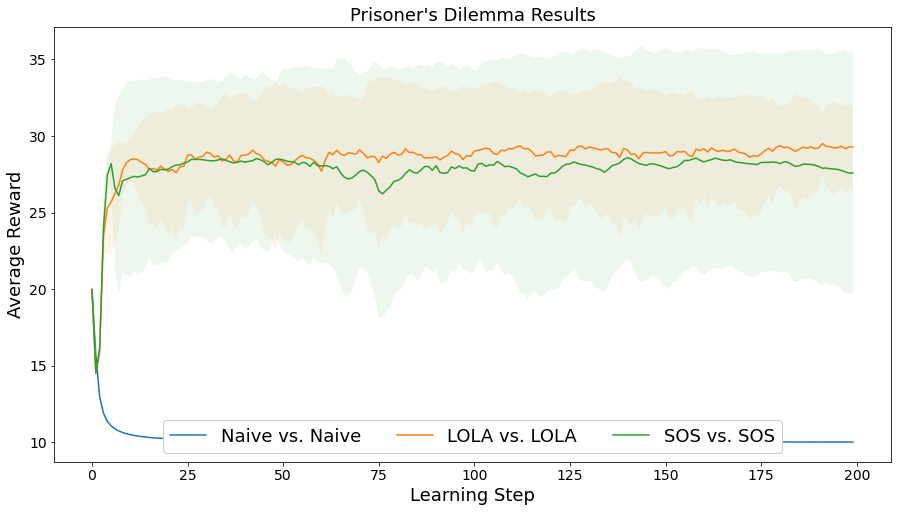

In [14]:
plt.figure(figsize=(15, 8))
for algo, outcomes in [('Naive', results_naive),
                       ('LOLA', results_lola),
                       ('SOS', results_sos), 
                       ]:
    Vs = np.array([[o['V_A'] for o in oo] for oo in outcomes] + \
                  [[o['V_B'] for o in oo] for oo in outcomes])
    means, stds = np.mean(Vs, axis=0), np.std(Vs, axis=0)
    steps = np.arange(len(means))
    plt.plot(steps, means, label=f"{algo} vs. {algo}")
    plt.fill_between(steps, means-stds, means+stds, alpha=0.08)
plt.title("Prisoner's Dilemma Results", fontsize=18)
plt.xlabel("Learning Step", fontsize=18)
plt.ylabel("Average Reward", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
plt.legend(loc='lower center', frameon=True, framealpha=1, ncol=3, fontsize=18)
plt.show()